In [40]:
import sys
import os
import os.path as osp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, SymLogNorm
import math
import _pickle as pickle

import astropy.constants as ac
import astropy.units as au

sys.path.insert(0,'..')
import pyathena as pa

In [2]:
import pandas as pd

from pyathena import LoadSim
from pyathena.util.units import Units

from pyathena.tigress_ncr.hst import Hst
from pyathena.tigress_ncr.load_sim_tigress_ncr import LoadSimTIGRESSNCRAll
from pyathena.fields import fields


In [3]:
models = dict(classic = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8/',
              ncr = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8/',
              no_spiral = '/data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8/',
              no_spiral_early = '/data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3/')
              #demo = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y2.xy1024.eps0.np768.has/')
sa = pa.LoadSimTIGRESSNCRAll(models)

# MODELS
ncr = sa.set_model('ncr')
classic = sa.set_model('classic')
no_spiral = sa.set_model('no_spiral')
no_spiral_early = sa.set_model('no_spiral_early')

LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8.
/home/comejuliet/miniconda3/envs/pyathena/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: vtk files 

In [4]:
#loading VTK files
s = ncr
ds = s.load_vtk(s.nums[5])
h = s.read_hst()

Text(0, 0.5, '$Q_{i}/{Area}[s^{-1}kpc^{-2}]$\n$\\Sigma_{SFR,10 Myr}x 10^{53} [M_{\\odot}kpc^-2yr^-1]$')

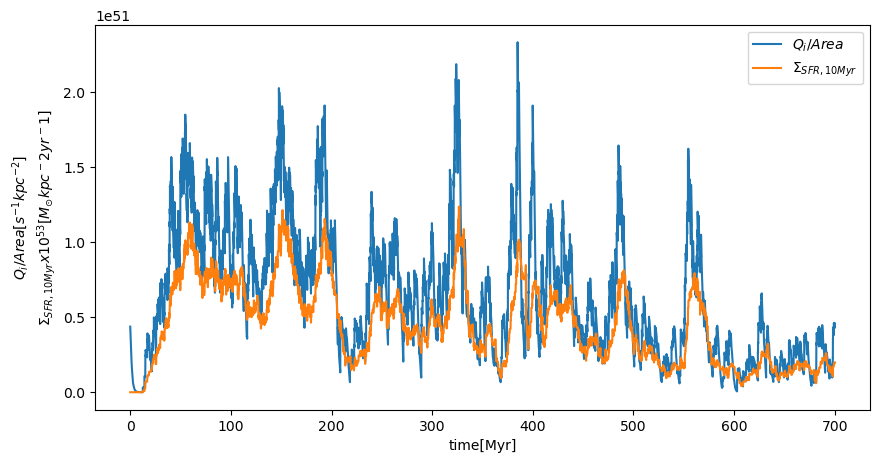

In [5]:
plt.figure(figsize=(10,5))
Lx = s.domain['Lx'][0]/10**3
Ly = s.domain['Lx'][1]/10**3
plt.plot(h['Qtot_PH']/(Lx*Ly),label='$Q_{i}/Area$')
plt.plot(h['sfr10']*1.e53, label='$\Sigma_{SFR,10Myr}$')
plt.legend()
plt.xlabel('time[Myr]')
plt.ylabel(r"$Q_{i}/{Area}[s^{-1}kpc^{-2}]$"
           "\n"
           r"$\Sigma_{SFR,10 Myr}x 10^{53} [M_{\odot}kpc^-2yr^-1]$")



## Calculation on Halpha emissivity

In [6]:
fields = ds.get_field(['T','nH','xe','j_Halpha','xHI','xH2','pressure','density'])

In [7]:
# code unit are stored as astropy.units objects
s.u.length, s.u.mass, s.u.time, s.u.velocity 

(<Quantity 1. pc>,
 <Quantity 0.03462449 solMass>,
 <Quantity 3.08567758e+13 s>,
 <Quantity 1. km / s>)

In [8]:
# To convert code time to Myr, we can multiply code_time by u.Myr
# That is, u.Myr = code.time.to('Myr').value
s.u.Myr, s.u.kms, s.u.Msun, s.u.pc, s.u.pc

(0.9777922216807893, 1.0, 0.0346244904274392, 1.0, 1.0)

In [9]:
# Halpha emissivity [erg/s/cm^-3/sr]
# Caution: Draine (2011)'s alpha_eff_Halpha valid for ~1000 K < T < ~30000 K
# Better to use this for warm gas only

hnu_Halpha = (ac.h*ac.c/(6562.8*au.angstrom)).to('erg')

# this is equivalent to T4 = fields['T']/1.e4
T4 = (fields['pressure']/(fields['density']*(1.1 + fields['xe'] - fields['xH2']))/\
                (ac.k_B/s.u.energy_density).cgs.value)/1e4

alpha_eff_Halpha = 1.17e-13*T4**(-0.942 -0.031 * np.log(T4))

idx = (T4 > 0.1) * (T4 < 3)
            
# Jeonggyu's procedure 
j_Halpha = fields['nH']**2*(1.0 - fields['xHI'] - fields['xH2'])*fields['xe']*\
            alpha_eff_Halpha*hnu_Halpha/(4.0*np.pi)

# Integration over the cylinder given by the telescope beam

In [10]:
# setting the domain and the dimensions for the different grids

dx = s.domain['dx'][0]
print(dx)

Nx = s.domain['Nx'][0]
Ny = s.domain['Nx'][1]
Lx = s.domain['Lx'][0]
Ly = s.domain['Lx'][1]
print(Lx,Ly)

L = []
spx = []
spy = []
for i in range (8):
    L.append(int(dx*2**i)) 
    spx.append(int(Lx/L[i]))
    spy.append(int(Ly/L[i]))
print('width of bins, L:', L)
print('number of superpixels in x, spx :',spx)
print('number of superpixels in y, spy :',spy)

8.0
2048.0 2048.0
width of bins, L: [8, 16, 32, 64, 128, 256, 512, 1024]
number of superpixels in x, spx : [256, 128, 64, 32, 16, 8, 4, 2]
number of superpixels in y, spy : [256, 128, 64, 32, 16, 8, 4, 2]


In [11]:
from scipy.interpolate import RegularGridInterpolator
# original grid 
nx, ny = (Nx, Ny)
x = np.linspace(-Lx/2, Lx/2, nx)
y = np.linspace(-Ly/2, Ly/2, ny)
xv, yv = np.meshgrid(x, y)

In [12]:
# Integration along the z-axis (face on view) in each pixel of the original grid to get a "luminosity surface density"
dz = s.domain['dx'][2]*ac.pc.cgs # Delta z in cm
dlum = 4.0*np.pi*j_Halpha.sum(dim='z')*dz.cgs.value # [erg/s/cm-2]
sigmaLUM = np.asarray(dlum)

In [44]:
# Regridding of sigmaLUM with CG's code

def rebin(arr, i):
    """Rebin 2D array. Coarsening by a factor of 2**i """
    f = 2**i
    new_shape =  arr.shape[0]//f, arr.shape[1]//f
    shape = (new_shape[0], f,
             new_shape[1], f)
    return arr.reshape(shape).mean(-1).mean(1)

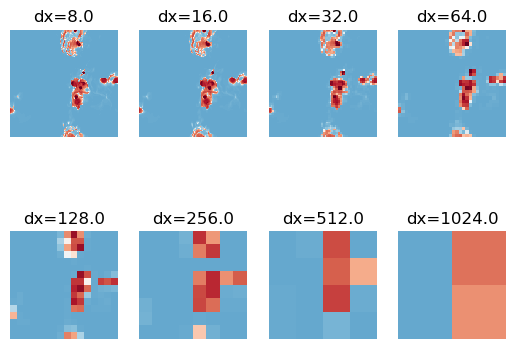

In [45]:
fig,axes = plt.subplots(2,4)
dx = s.domain['dx'][0]
for i,ax in enumerate(axes.flatten()):
    sigmaLUM_down = rebin(sigmaLUM,i)
    dmap = sigmaLUM_down/sigmaLUM_down.mean()-1
    

    plt.sca(ax)
    plt.imshow(dmap,norm=SymLogNorm(0.1,vmin=-100,vmax=100),
               cmap=plt.cm.RdBu_r,interpolation='nearest')
    plt.title('dx={}'.format(dx*2**i))
    plt.axis('off')

In [46]:
# and we calculate the auto correlation function of SigmaSFR_Halpha
def get_correlation(map1,map2=None,Nbin=8,return_map=False):
    """Calculate zero desplacement correlation value with different smoothing

    Parameters
    ==========
    map1 : array
    map2 : array
        if not specified, it will calculate auto correlation for map1
    return_map : bool
        if True, it will return maps rather than the correlation coefficient.
    overdensity definition:
        delta_L = (rho_L - <rho_L>)/<rho_L>

    zero-displacement auto correlation is basically a variance at scale L normalized by mean^2
    xi_L = <delta_L^2> = var_L/<rho_L>^2
    """
    corr=[]
    if return_map:
        maps = []
    for i in range(Nbin):
        submap1 = rebin(map1,i)
        dmap1 = (submap1-submap1.mean())/submap1.mean()
        if map2 is not None:
            submap2 = rebin(map2,i)
            dmap2 = (submap2-submap2.mean())/submap2.mean()
        else:
            dmap2 = dmap1
        corr.append((dmap1*dmap2).mean())
        if return_map: maps.append(dmap1*dmap2)
    if return_map:
        return maps

    return corr
        

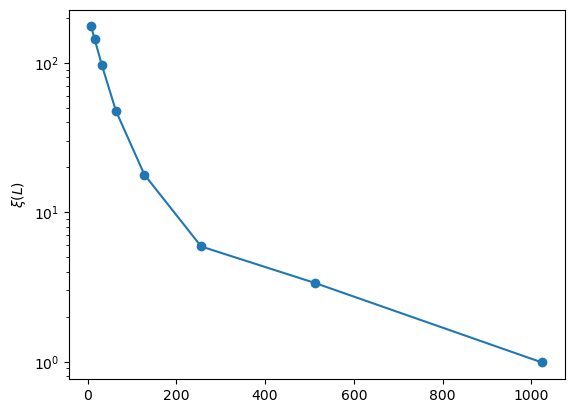

In [47]:
Nbin=8
L = s.domain['dx'][0]*2**np.arange(Nbin)
corr = get_correlation(sigmaLUM,return_map=False)
plt.plot(L,corr,'o-')
plt.ylabel(r'$\xi(L)$')
plt.yscale('log')

In [48]:
# Regridding of the luminosity surface density (my procedure)

interp = RegularGridInterpolator((y, x), sigmaLUM, bounds_error=False, fill_value=None)
sigmalow_LUM = []
sigmaLUM_avg = []
for k in range(8):
    nxx, nyy = (spx[k], spy[k])
    xx = np.linspace(-Lx/2, Lx/2, nxx)
    yy = np.linspace(-Ly/2, Ly/2, nyy)
    xxv, yyv = np.meshgrid(xx, yy)
    sigmalow_LUM.append(interp((yyv,xxv)))
    sigmaLUM_avg.append(sigmalow_LUM[k].mean()) #[erg/s/cm-2]
    

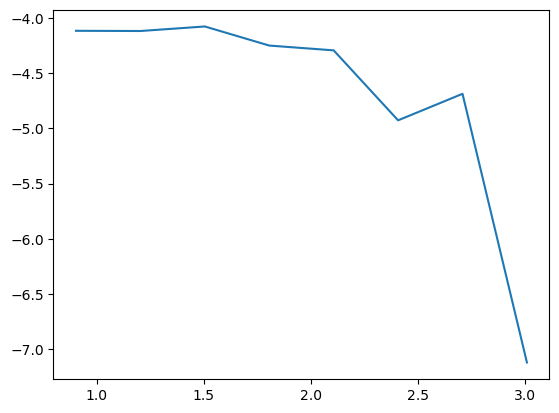

In [49]:
plt.plot(np.log10(L),np.log10(sigmaLUM_avg))

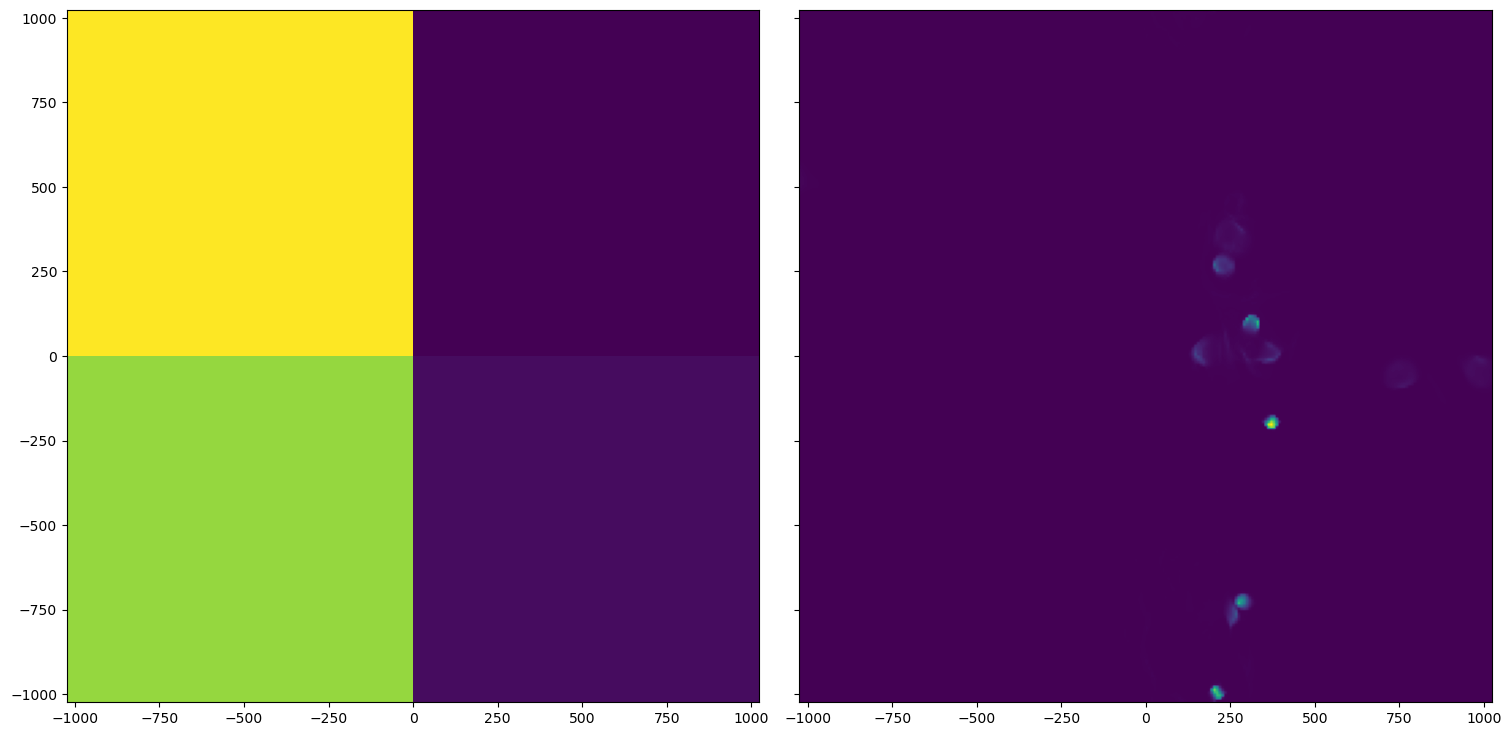

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15,10), sharey = True,layout="constrained")
im1 = axes[0].imshow(sigmalow_LUM[7], origin='lower', extent=[-Lx/2,Lx/2,-Ly/2,Ly/2])
im2 = axes[1].imshow(sigmaLUM, origin='lower', extent=[-Lx/2,Lx/2,-Ly/2,Ly/2])

plt.show()

In [52]:
lum = []
SFR_Halpha = []
for k in range(8):
    area = (Lx*3.0856776e18)*(Ly*3.0856776e18)
    lum.append(sigmaLUM_avg[k]*area)
    SFR_Halpha.append(7.9e-42*lum[k])
#[erg/s]

## SFR from star particles

In [53]:
# setting the domain and the dimensions for the different grids

dx = s.domain['dx'][0]
print(dx)

Nx = s.domain['Nx'][0]
Ny = s.domain['Nx'][1]
Lx = s.domain['Lx'][0]
Ly = s.domain['Lx'][1]
print(Lx,Ly)

L = []
spx = []
spy = []
for i in range (8):
    L.append(int(dx*2**i)) 
    spx.append(int(Lx/L[i]))
    spy.append(int(Ly/L[i]))
print('width of bins, L:', L)
print('number of superpixels in x, spx :',spx)
print('number of superpixels in y, spy :',spy)

8.0
2048.0 2048.0
width of bins, L: [8, 16, 32, 64, 128, 256, 512, 1024]
number of superpixels in x, spx : [256, 128, 64, 32, 16, 8, 4, 2]
number of superpixels in y, spy : [256, 128, 64, 32, 16, 8, 4, 2]


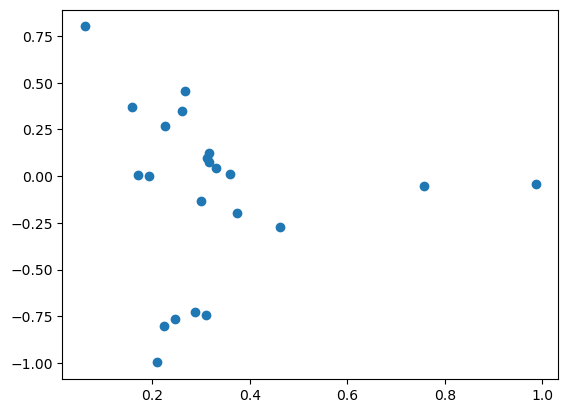

In [54]:
agemax = 10

def mass_norm(mass):
    return np.sqrt(mass/10)

sp1 = s.load_starpar_vtk(num=s.nums[5])
sp1['mage'] *= s.u.Myr
sp1['mass'] *= s.u.Msun
sp1['x1'] *= s.u.kpc
sp1['x2'] *= s.u.kpc
sp1['x3'] *= s.u.kpc
sp1 = sp1[sp1.mage<agemax]
runaway=sp1['mass'] == 0
cluster=sp1['mass'] != 0

spyoungcluster = sp1[cluster]

plt.scatter(spyoungcluster['x1'], spyoungcluster['x2'], marker='o')

In [55]:
# defining a function for reading the starpar file
def sp_reader(number):
    
    sp = s.load_starpar_vtk(num=number)
    sp['mage'] *= s.u.Myr
    sp['mass'] *= s.u.Msun
    sp['x1'] *= s.u.pc
    sp['x2'] *= s.u.pc
    # first, select only young star particles
    # "young" is a boolean array: True for young, False for old
    #sp = sp['age'] < 40.
    spyoung = sp[sp.mage<10]
    # second, separate clusters (mass != 0) and runaways (mass == 0)
    # mass of runaway OB stars was set to zero
    # "runaway" and "cluster" are also boolean arrays
    runaway=sp['mass'] == 0
    cluster=sp['mass'] != 0

    # young * cluster is True for young and cluster particles
    #young_cluster = young & cluster
    #spyoung = sp[young_cluster]
    spyoungcluster = spyoung[cluster]

    #return spyoung
    return spyoungcluster

/tmp/ipykernel_107451/1523485181.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spyoungcluster = spyoung[cluster]


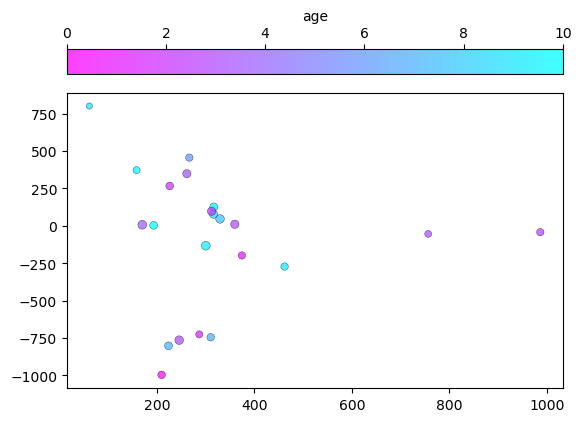

In [56]:
# read just one snapshot and plot the star particles to check 
def mass_norm(mass):
    return np.sqrt(mass/10)

sp = sp_reader(s.nums[5])

stars = plt.scatter(sp['x1'], sp['x2'], marker='o', c=sp.age, s= mass_norm(sp.mass),
                edgecolor='black', vmin = 0, vmax = 10, linewidth=0.3, cmap='cool_r', zorder=2, alpha=0.75)

plt.colorbar(stars,label='age',location='top')

total_mass = np.sum(sp['mass'])

In [57]:
# build sigmaSFR matrix and calculate autocorrelation function

nums = s.nums
npt = len(nums)

csi_SFR = []
sp = sp_reader(s.nums[5])
csi_avg = []
sigmaSFR_avg = []
for k in range(8):
    nx, ny, nL = (spx[k], spy[k], L[k])
    spi = [0.0]*(nx)
    spj = [0.0]*(ny)
    spij = np.zeros((ny,nx), dtype = object)
    msp = np.zeros((ny,nx))
    sigmaSFR = np.zeros((ny,nx))
    deltaS = np.zeros((ny,nx))
    csi = np.zeros((ny,nx))

    test_spx = np.array(sp.x1)
    test_spy = np.array(sp.x2)

    for j in range (ny):
        spj[j] = np.logical_and((test_spy+Ly/2)/nL>=j, (test_spy+Ly/2)/nL<j+1)
    for i in range (nx):
        spi[i] = np.logical_and((test_spx+Lx/2)/nL>=i, (test_spx+Lx/2)/nL<i+1)

    for j in range(ny):
        for i in range (nx):
            spij[j,i] = spi[i]*spj[j]
            msp[j,i] = np.sum(sp[spij[j,i]].mass)
            sigmaSFR[j,i] = msp[j,i]/(10*nL*nL)
    #sigmaSFR_avgvalue.append(sigmaSFR.mean())
    #print(sigmaSFR.mean())

    idx = np.where(sigmaSFR != 0)
    sigmaSFR_nonzero = sigmaSFR[idx]
    
    sigmaSFR_avg.append(sigmaSFR_nonzero.mean())
    
SFR_sp = np.asarray(sigmaSFR_avg)*Lx*Ly/1.e6 

/tmp/ipykernel_107451/1523485181.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  spyoungcluster = spyoung[cluster]


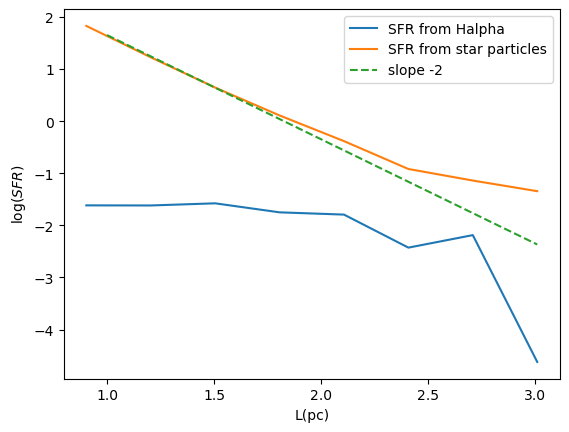

In [24]:
plt.plot(np.log10(L),np.log10(SFR_Halpha),label = 'SFR from Halpha') 
plt.plot(np.log10(L),np.log10(SFR_sp), label = 'SFR from star particles') 
#plt.plot(np.log10(L),np.log10(sigmaSFR_avg_sp))
vx = np.logspace(1,3.01029996,100)
vy = (4.5e3)*vx**(-2)

plt.plot(np.log10(vx),np.log10(vy),'--', label = 'slope -2')
plt.xlabel('L(pc)')
plt.ylabel(r'$\log(SFR)$')
plt.legend()